In [47]:
import random
import itertools
from collections import namedtuple

import gym
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
env = gym.make('CartPole-v0')

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.index = 0
        
    def add(self, state, action, next_state, reward):
        if len(self.buffer) < self.capacity:
            self.buffer.append([])
        self.buffer[self.index] = Transition(state, action, next_state, reward)
        self.index = (self.index + 1) % self.capacity
        
    def get_sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_DECAY = 200
EPS_END = 0.05
TARGET_UPDATE = 10


class DQN(torch.nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(32)
        self.output = torch.nn.Linear(2 * 7 * 32, 2)
        self.steps = 0
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.output(x.view(x.size(0), -1))
    
    def get_action(self, state, _eval=False):
        eps_thresh = EPS_END + (EPS_START - EPS_END) * np.exp(-1.0 * self.steps / EPS_DECAY)
        self.steps += 1
        if random.random() > eps_thresh or _eval:
            with torch.no_grad():
                return self(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)
    

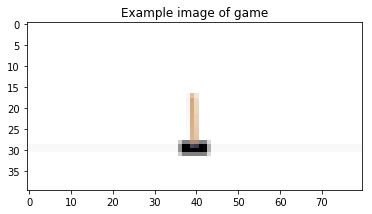

In [50]:
total_width = 600 #px

resize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((40, 80)),
    torchvision.transforms.ToTensor()
])

def get_image():
    
    # reshape from (H, W, C) -> (C, H, W)
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)
    
#     cart_location = int(env.state[0] * total_width / (env.x_threshold * 2) + (total_width / 2.0))
#     # crop out some of the height of the image
#     screen = screen[:, 160:320]
#     crop_width = 320
    
#     # width cropping
#     if cart_location < crop_width // 2:
#         screen = screen[:, :, :crop_width]
#     elif cart_location > (total_width - (crop_width // 2)):
#         screen = screen[:, :, -crop_width:]
#     else:
#         screen = screen[:, :, cart_location - (crop_width // 2) : cart_location + (crop_width // 2)]
        
#     screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
#     screen = torch.from_numpy(screen)
#     return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_image().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Example image of game')
plt.show()
env.close()

In [51]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_DECAY = 200
EPS_END = 0.05
TARGET_UPDATE = 10

In [32]:
net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=448, out_features=2, bias=True)
)

In [52]:
optimizer = torch.optim.RMSprop(net.parameters())
replay_buffer = ReplayBuffer(10000)

In [34]:
def train_step():
    if len(replay_buffer.buffer) < BATCH_SIZE:
        return
    
    samples = replay_buffer.get_sample(BATCH_SIZE)
    batch = Transition(*zip(*samples))
    
         # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

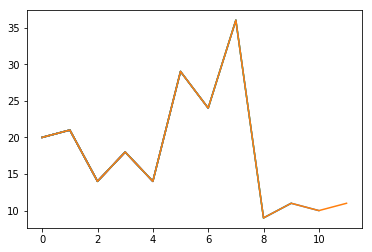

KeyboardInterrupt: 

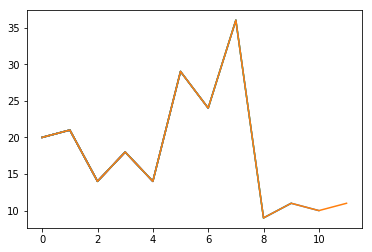

In [53]:
num_episodes = 100
rewards = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_image()
    current_screen = get_image()
    state = current_screen - last_screen
    #print(state.shape)
    reward_sum = 0
    for t in itertools.count():
        # Select and perform an action
        action = net.get_action(state)
        _, reward, done, _ = env.step(action.item())
        reward_sum += reward
        reward = torch.tensor([reward], device=device)
        # Observe new state
        last_screen = current_screen
        current_screen = get_image()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        replay_buffer.add(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        train_step()
        if done:
            rewards.append(reward_sum)
            plt.plot(rewards)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [36]:
durations = []
num_eval_episodes = 50
for i_eval_episode in range(num_eval_episodes):
    env.reset()
    last_screen = get_image()
    current_screen = get_image()
    state = current_screen - last_screen
    for t in itertools.count():
        action = net.get_action(state, _eval=True)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_image()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Move to the next state
        state = next_state

        if done:
            durations.append(t)
            break
env.close() 

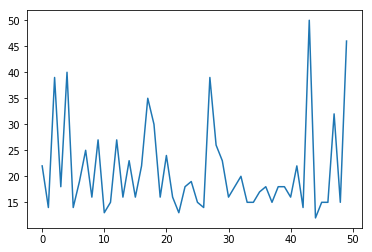

In [37]:
plt.plot(durations)

In [38]:
env.close()

In [39]:
env.reward_range

(-inf, inf)

In [40]:
np.mean(rewards)

22.14

In [41]:
np.mean(durations)

21.22

In [42]:
screen = get_image()

In [43]:
screen.size()

torch.Size([1, 3, 40, 80])

In [44]:
!pip install torchsummary

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [45]:
from torchsummary import summary

In [46]:
summary(net, input_size=(3, 40, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 18, 38]           1,216
       BatchNorm2d-2           [-1, 16, 18, 38]              32
            Conv2d-3            [-1, 32, 7, 17]          12,832
       BatchNorm2d-4            [-1, 32, 7, 17]              64
            Conv2d-5             [-1, 32, 2, 7]          25,632
       BatchNorm2d-6             [-1, 32, 2, 7]              64
            Linear-7                    [-1, 2]             898
Total params: 40,738
Trainable params: 40,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.23
Params size (MB): 0.16
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


448